In [1]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import align_trials
from ephysvibe.task import task_constants
import os 
from matplotlib import cm
import glob
import pickle
seed = 2023

In [2]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [3]:
def scale_p(x, out_range=(-1, 1)):
    if np.sum(x>1) >0:
        return
    domain = 0, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [6]:
def compute_roc_auc(group1,group2):
    rng = np.random.default_rng(seed=seed)
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]

        # Wilcoxon rank-sum 
        p.append(stats.ttest_ind(g1, g2)[1])#stats.ttest_ind

        thresholds = np.unique(np.concatenate([g1,g2]))

        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
                      
            score = metrics.auc(fpr[fpr.argsort()],tpr[fpr.argsort()])
        roc_score.append(score)
        
    roc_score = np.array(roc_score)
    roc_score = scale_p(np.round(roc_score,2),out_range=[-1,1])
    return roc_score, p


In [7]:
def definelatencies(p_values, win, threshold):

   lat=[]

   for i in np.arange(p_values.shape[0]):
      
      tmp=[]
      
      sig=np.zeros(p_values.shape[1])
      sig[np.where(p_values[i,:]<0.01)]=1
      
      for i_step in np.arange(sig.shape[0]):
         if sig[i_step]==1 and np.sum(sig[i_step:i_step+win])>=threshold:
            tmp.append(i_step)  

      if not tmp:
         lat.append(np.nan)  
      else:
         lat.append(tmp[0])  
      
   lat=np.array(lat)

   return lat


In [8]:
directory_b1    =   "W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/"
bhv_directory   =   os.path.normpath(str(directory_b1) +  "/bhv/")

area="pfc"
neurons_pfc_directory =   os.path.normpath(str(directory_b1) + area + "/neurons/*.h5")
neurons_pfc_files     =   glob.glob(neurons_pfc_directory, recursive=True)

area="v4"
neurons_v4_directory =   os.path.normpath(str(directory_b1) + area + "/neurons/*.h5")
neurons_v4_files     =   glob.glob(neurons_v4_directory, recursive=True)

area="lip"

neurons_lip_directory =   os.path.normpath(str(directory_b1) + area + "/neurons/*.h5")
neurons_lip_files     =   glob.glob(neurons_lip_directory, recursive=True)

In [32]:
sp_sample_in_on,mask_sample_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )

sp_sample_out_on,mask_sample_out = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= -1,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )

In [36]:
pfc_sample_in_avg_sp[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
sp_t1_in_on,mask_t1_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="test_on_1",
            time_before = time_before_t1,
            error_type= 0,
        )
sp_t1_out_on,mask_t1_in = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= -1,
        event ="test_on_1",
        time_before = time_before_t1,
        error_type= 0,
    )

pfc_t1_in_avg_sp       =   moving_average(data=sp_t1_in_on[:, :timetotal_t1],win=win, step=step)[:,:-win]
pfc_t1_out_avg_sp       =   moving_average(data=sp_t1_out_on[:, :timetotal_t1],win=win, step=step)[:,:-win]

t_pos, p_t_pos  = compute_roc_auc(pfc_t1_in_avg_sp, pfc_t1_out_avg_sp)

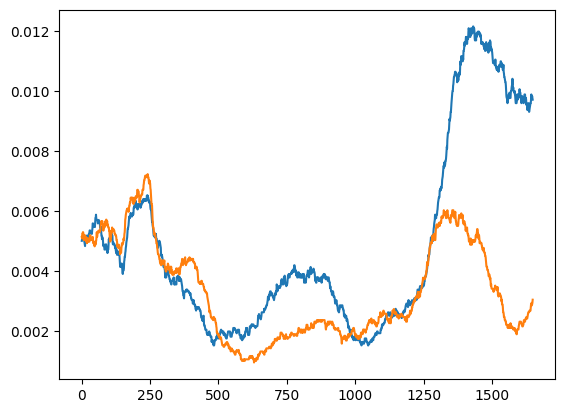

In [53]:
plt.plot(np.mean(pfc_sample_in_avg_sp, axis=0))
plt.plot(np.mean(pfc_sample_out_avg_sp, axis=0))

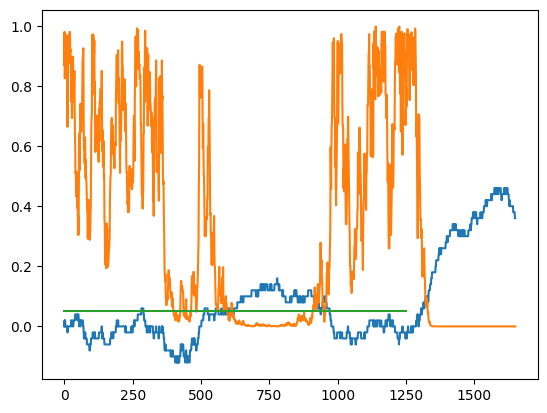

In [54]:
plt.plot(s_pos)
plt.plot(p_s_pos)
plt.plot([0, 1250], [0.05, 0.05])

In [8]:
## pfc

code=1
select_block=1
time_before_sample  =   400
time_before_t1      =   450

timetotal_sample=   time_before_sample+450*3
timetotal_t1    =   time_before_t1+450*2
win=100
step=1

pfc_paths=neurons_pfc_files
numcells=1#len(neurons_pfc_files)

all_pfc_s_orient_value      =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_pfc_s_color_value       =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_pfc_s_neutral_value     =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_pfc_s_pos_value         =   np.empty((numcells,timetotal_sample-win,))*np.nan

all_pfc_s_orient_p          =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_pfc_s_color_p           =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_pfc_s_neutral_p         =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_pfc_s_pos_p             =   np.empty((numcells,timetotal_sample-win,))*np.nan

all_pfc_t_orient_value      =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_pfc_t_color_value       =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_pfc_t_neutral_value     =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_pfc_t_pos_value         =   np.empty((numcells,timetotal_sample-win,))*np.nan

all_pfc_t_orient_p          =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_pfc_t_color_p           =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_pfc_t_neutral_p         =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_pfc_t_pos_p             =   np.empty((numcells,timetotal_sample-win,))*np.nan

n=0

for p in pfc_paths[:numcells]:
    print(str(n) + "/" + str(len(pfc_paths)))
    pfc_good, pfc_mua = 1, 1
    
    neu_data    =   NeuronData.from_python_hdf5(p)
    date_time   =   neu_data.date_time
    
    # path_bhv    =   glob.glob(os.path.normpath(str(bhv_pfc_directory) + "/" + str(date_time) + "*.h5"))[0]
    # bhv_data    =   BhvData.from_python_hdf5 (path_bhv) 
    if neu_data.cluster_group == "good":
        # i_cluster = i_good
        pfc_good += 1
        cluster = "neuron"

    else:
        # i_cluster = i_mua
        pfc_mua += 1
    
    sp_sample_in_on,mask_sample_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )

    sp_sample_out_on,mask_sample_out = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= -1,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )
    
    sp_t1_in_on,mask_t1_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="test_on_1",
            time_before = time_before_t1,
            error_type= 0,
        )
    sp_t1_out_on,mask_t1_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= -1,
            event ="test_on_1",
            time_before = time_before_t1,
            error_type= 0,
        )

    o1trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==1)
    o5trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==5)
    
    c1trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==1)
    c5trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==5)
    
    ntrials     =   np.where(neu_data.sample_id[mask_sample_in]==0)
    nntrials    =   np.where(neu_data.sample_id[mask_sample_in]!=0)



    pfc_sample_in_avg_sp   =   moving_average(data=sp_sample_in_on[:, :timetotal_sample],win=win, step=step)[:,:-win]
    pfc_sample_out_avg_sp   =   moving_average(data=sp_sample_out_on[:, :timetotal_sample],win=win, step=step)[:,:-win]
    pfc_t1_in_avg_sp       =   moving_average(data=sp_t1_in_on[:, :timetotal_t1],win=win, step=step)[:,:-win]
    pfc_t1_out_avg_sp       =   moving_average(data=sp_t1_out_on[:, :timetotal_t1],win=win, step=step)[:,:-win]


    s_color, p_s_color  =   compute_roc_auc(pfc_sample_in_avg_sp[c1trials, :][0], pfc_sample_in_avg_sp[c5trials, :][0])
    s_orient,p_s_orient =   compute_roc_auc(pfc_sample_in_avg_sp[o1trials, :][0], pfc_sample_in_avg_sp[o5trials, :][0])
    sample_s_neutral, p_s_sample_neutral    =   compute_roc_auc(pfc_sample_in_avg_sp[nntrials, :][0], pfc_sample_in_avg_sp[ntrials, :][0])
    s_pos, p_s_pos      =   compute_roc_auc(pfc_sample_in_avg_sp, pfc_sample_out_avg_sp)

    t_color, p_t_color  = compute_roc_auc(pfc_t1_in_avg_sp[c1trials, :][0], pfc_t1_in_avg_sp[c5trials, :][0])
    t_orient,p_t_orient = compute_roc_auc(pfc_t1_in_avg_sp[o1trials, :][0], pfc_t1_in_avg_sp[o5trials, :][0])
    sample_t_neutral, p_t_sample_neutral    =   compute_roc_auc(pfc_t1_in_avg_sp[nntrials, :][0], pfc_t1_in_avg_sp[ntrials, :][0])
    t_pos, p_t_pos  = compute_roc_auc(pfc_t1_in_avg_sp, pfc_t1_out_avg_sp)
    
    all_pfc_s_orient_value[n, :]    =   s_orient
    all_pfc_s_color_value[n, :]     =   s_color
    all_pfc_s_neutral_value[n, :]   =   sample_s_neutral
    all_pfc_s_pos_value[n,:]        =   s_pos

    all_pfc_s_orient_p[n, :]        =   p_s_orient
    all_pfc_s_color_p[n, :]         =   p_s_color
    all_pfc_s_neutral_p[n, :]       =   p_s_sample_neutral
    all_pfc_s_pos_p[n,:]            =   p_s_pos

    all_pfc_t_orient_value[n, :]    =   t_orient
    all_pfc_t_color_value[n, :]     =   t_color
    all_pfc_t_neutral_value[n, :]   =   sample_t_neutral
    all_pfc_t_pos_value[n,:]        =   t_pos

    all_pfc_t_orient_p[n, :]        =   p_t_orient
    all_pfc_t_color_p[n, :]         =   p_t_color
    all_pfc_t_neutral_p[n, :]       =   p_t_sample_neutral
    all_pfc_t_pos_p[n,:]            =   p_t_pos

    n+=1



lat_pfc_orient  =   definelatencies(all_pfc_s_orient_p, win=75, threshold=75)
lat_pfc_color   =   definelatencies(all_pfc_s_color_p, win=75, threshold=75)
lat_pfc_neutral =   definelatencies(all_pfc_s_neutral_p, win=75, threshold=75)
lat_pfc_pos     =   definelatencies(all_pfc_s_pos_p, win=75, threshold=75)




pfc_sample_s_ROC_values =   ["ROC value sample neutral", all_pfc_s_neutral_value, "ROC value sample orient", all_pfc_s_orient_value, "ROC value sample color", all_pfc_s_color_value, "ROC value sample position", all_pfc_s_pos_value]
pfc_sample_s_ROC_p      =   ["p value sample neutral", all_pfc_s_neutral_p, "p value sample orient", all_pfc_s_orient_p, "p value sample color", all_pfc_s_color_p, "p value sample position", all_pfc_s_pos_p]
pfc_sample_t_ROC_values =   ["ROC value t1 neutral", all_pfc_t_neutral_value, "ROC value T1 orient", all_pfc_t_orient_value, "ROC value T1 color", all_pfc_t_color_value, "ROC value T1 position", all_pfc_t_pos_value]
pfc_sample_t_ROC_p      =   ["p value t1 neutral", all_pfc_t_neutral_p, "p value T1 orient", all_pfc_t_orient_p, "p value T1 color", all_pfc_t_color_p, "p value T1 position", all_pfc_t_pos_p]
pfc_sample_latencies    =   ["Neutral sample lat", lat_pfc_neutral, "orient sample lat", lat_pfc_orient, "color sample lat", lat_pfc_color, "pos sample lat", lat_pfc_pos]

pfc_sample_ROC_analyses  =   [pfc_sample_s_ROC_values, pfc_sample_s_ROC_p, pfc_sample_t_ROC_values, pfc_sample_t_ROC_p, pfc_sample_latencies]
with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/pfcsampleROC", "wb") as fp: 
    pickle.dump(pfc_sample_ROC_analyses, fp)


0/1478
1/1478


In [ ]:
## v4

code=1
select_block=1
time_before_sample  =   400
time_before_t1      =   450

timetotal_sample=   time_before_sample+450*3
timetotal_t1    =   time_before_t1+450*2
win=100
step=1

v4_paths=neurons_v4_files
numcells=1#len(neurons_v4_files)

all_v4_s_orient_value      =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_v4_s_color_value       =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_v4_s_neutral_value     =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_v4_s_pos_value         =   np.empty((numcells,timetotal_sample-win,))*np.nan

all_v4_s_orient_p          =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_v4_s_color_p           =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_v4_s_neutral_p         =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_v4_s_pos_p             =   np.empty((numcells,timetotal_sample-win,))*np.nan

all_v4_t_orient_value      =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_v4_t_color_value       =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_v4_t_neutral_value     =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_v4_t_pos_value         =   np.empty((numcells,timetotal_sample-win,))*np.nan

all_v4_t_orient_p          =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_v4_t_color_p           =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_v4_t_neutral_p         =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_v4_t_pos_p             =   np.empty((numcells,timetotal_sample-win,))*np.nan

n=0

for p in v4_paths[:numcells]:
    print(str(n) + "/" + str(len(v4_paths)))
    v4_good, v4_mua = 1, 1
    
    neu_data    =   NeuronData.from_python_hdf5(p)
    date_time   =   neu_data.date_time
    
    # path_bhv    =   glob.glob(os.path.normpath(str(bhv_v4_directory) + "/" + str(date_time) + "*.h5"))[0]
    # bhv_data    =   BhvData.from_python_hdf5 (path_bhv) 
    if neu_data.cluster_group == "good":
        # i_cluster = i_good
        v4_good += 1
        cluster = "neuron"

    else:
        # i_cluster = i_mua
        v4_mua += 1
    
    sp_sample_in_on,mask_sample_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )

    sp_sample_out_on,mask_sample_out = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= -1,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )
    
    sp_t1_in_on,mask_t1_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="test_on_1",
            time_before = time_before_t1,
            error_type= 0,
        )
    sp_t1_out_on,mask_t1_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= -1,
            event ="test_on_1",
            time_before = time_before_t1,
            error_type= 0,
        )

    o1trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==1)
    o5trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==5)
    
    c1trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==1)
    c5trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==5)
    
    ntrials     =   np.where(neu_data.sample_id[mask_sample_in]==0)
    nntrials    =   np.where(neu_data.sample_id[mask_sample_in]!=0)



    v4_sample_in_avg_sp   =   moving_average(data=sp_sample_in_on[:, :timetotal_sample],win=win, step=step)[:,:-win]
    v4_sample_out_avg_sp   =   moving_average(data=sp_sample_out_on[:, :timetotal_sample],win=win, step=step)[:,:-win]
    v4_t1_in_avg_sp       =   moving_average(data=sp_t1_in_on[:, :timetotal_t1],win=win, step=step)[:,:-win]
    v4_t1_out_avg_sp       =   moving_average(data=sp_t1_out_on[:, :timetotal_t1],win=win, step=step)[:,:-win]


    s_color, p_s_color  =   compute_roc_auc(v4_sample_in_avg_sp[c1trials, :][0], v4_sample_in_avg_sp[c5trials, :][0])
    s_orient,p_s_orient =   compute_roc_auc(v4_sample_in_avg_sp[o1trials, :][0], v4_sample_in_avg_sp[o5trials, :][0])
    sample_s_neutral, p_s_sample_neutral    =   compute_roc_auc(v4_sample_in_avg_sp[nntrials, :][0], v4_sample_in_avg_sp[ntrials, :][0])
    s_pos, p_s_pos      =   compute_roc_auc(v4_sample_in_avg_sp, v4_sample_out_avg_sp)

    t_color, p_t_color  = compute_roc_auc(v4_t1_in_avg_sp[c1trials, :][0], v4_t1_in_avg_sp[c5trials, :][0])
    t_orient,p_t_orient = compute_roc_auc(v4_t1_in_avg_sp[o1trials, :][0], v4_t1_in_avg_sp[o5trials, :][0])
    sample_t_neutral, p_t_sample_neutral    =   compute_roc_auc(v4_t1_in_avg_sp[nntrials, :][0], v4_t1_in_avg_sp[ntrials, :][0])
    t_pos, p_t_pos  = compute_roc_auc(v4_t1_in_avg_sp, v4_t1_out_avg_sp)
    
    all_v4_s_orient_value[n, :]    =   s_orient
    all_v4_s_color_value[n, :]     =   s_color
    all_v4_s_neutral_value[n, :]   =   sample_s_neutral
    all_v4_s_pos_value[n,:]        =   s_pos

    all_v4_s_orient_p[n, :]        =   p_s_orient
    all_v4_s_color_p[n, :]         =   p_s_color
    all_v4_s_neutral_p[n, :]       =   p_s_sample_neutral
    all_v4_s_pos_p[n,:]            =   p_s_pos

    all_v4_t_orient_value[n, :]    =   t_orient
    all_v4_t_color_value[n, :]     =   t_color
    all_v4_t_neutral_value[n, :]   =   sample_t_neutral
    all_v4_t_pos_value[n,:]        =   t_pos

    all_v4_t_orient_p[n, :]        =   p_t_orient
    all_v4_t_color_p[n, :]         =   p_t_color
    all_v4_t_neutral_p[n, :]       =   p_t_sample_neutral
    all_v4_t_pos_p[n,:]            =   p_t_pos

    n+=1



lat_v4_orient  =   definelatencies(all_v4_s_orient_p, win=75, threshold=75)
lat_v4_color   =   definelatencies(all_v4_s_color_p, win=75, threshold=75)
lat_v4_neutral =   definelatencies(all_v4_s_neutral_p, win=75, threshold=75)
lat_v4_pos     =   definelatencies(all_v4_s_pos_p, win=75, threshold=75)




v4_sample_s_ROC_values =   ["ROC value sample neutral", all_v4_s_neutral_value, "ROC value sample orient", all_v4_s_orient_value, "ROC value sample color", all_v4_s_color_value, "ROC value sample position", all_v4_s_pos_value]
v4_sample_s_ROC_p      =   ["p value sample neutral", all_v4_s_neutral_p, "p value sample orient", all_v4_s_orient_p, "p value sample color", all_v4_s_color_p, "p value sample position", all_v4_s_pos_p]
v4_sample_t_ROC_values =   ["ROC value t1 neutral", all_v4_t_neutral_value, "ROC value T1 orient", all_v4_t_orient_value, "ROC value T1 color", all_v4_t_color_value, "ROC value T1 position", all_v4_t_pos_value]
v4_sample_t_ROC_p      =   ["p value t1 neutral", all_v4_t_neutral_p, "p value T1 orient", all_v4_t_orient_p, "p value T1 color", all_v4_t_color_p, "p value T1 position", all_v4_t_pos_p]
v4_sample_latencies    =   ["Neutral sample lat", lat_v4_neutral, "orient sample lat", lat_v4_orient, "color sample lat", lat_v4_color, "pos sample lat", lat_v4_pos]

v4_sample_ROC_analyses  =   [v4_sample_s_ROC_values, v4_sample_s_ROC_p, v4_sample_t_ROC_values, v4_sample_t_ROC_p, v4_sample_latencies]
with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/v4sampleROC", "wb") as fp: 
    pickle.dump(v4_sample_ROC_analyses, fp)


SyntaxError: invalid syntax (2852555604.py, line 63)

In [47]:
## lip

code=1
select_block=1
time_before_sample  =   400
time_before_t1      =   450

timetotal_sample=   time_before_sample+450*3
timetotal_t1    =   time_before_t1+450*2
win=100
step=1

lip_paths=neurons_lip_files
numcells=1#len(neurons_lip_files)

all_lip_s_orient_value      =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_lip_s_color_value       =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_lip_s_neutral_value     =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_lip_s_pos_value         =   np.empty((numcells,timetotal_sample-win,))*np.nan

all_lip_s_orient_p          =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_lip_s_color_p           =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_lip_s_neutral_p         =   np.empty((numcells,timetotal_sample-win,))*np.nan
all_lip_s_pos_p             =   np.empty((numcells,timetotal_sample-win,))*np.nan

all_lip_t_orient_value      =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_lip_t_color_value       =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_lip_t_neutral_value     =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_lip_t_pos_value         =   np.empty((numcells,timetotal_sample-win,))*np.nan

all_lip_t_orient_p          =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_lip_t_color_p           =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_lip_t_neutral_p         =   np.empty((numcells,timetotal_t1-win,))*np.nan
all_lip_t_pos_p             =   np.empty((numcells,timetotal_sample-win,))*np.nan

n=0

for p in lip_paths[:numcells]:
    print(str(n) + "/" + str(len(lip_paths)))
    lip_good, lip_mua = 1, 1
    
    neu_data    =   NeuronData.from_python_hdf5(p)
    date_time   =   neu_data.date_time
    
    # path_bhv    =   glob.glob(os.path.normpath(str(bhv_lip_directory) + "/" + str(date_time) + "*.h5"))[0]
    # bhv_data    =   BhvData.from_python_hdf5 (path_bhv) 
    if neu_data.cluster_group == "good":
        # i_cluster = i_good
        lip_good += 1
        cluster = "neuron"

    else:
        # i_cluster = i_mua
        lip_mua += 1
    
    sp_sample_in_on,mask_sample_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )

    sp_sample_out_on,mask_sample_out = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= -1,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )
    
    sp_t1_in_on,mask_t1_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="test_on_1",
            time_before = time_before_t1,
            error_type= 0,
        )
    sp_t1_out_on,mask_t1_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= -1,
            event ="test_on_1",
            time_before = time_before_t1,
            error_type= 0,
        )

    o1trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==1)
    o5trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==5)
    
    c1trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==1)
    c5trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==5)
    
    ntrials     =   np.where(neu_data.sample_id[mask_sample_in]==0)
    nntrials    =   np.where(neu_data.sample_id[mask_sample_in]!=0)



    lip_sample_in_avg_sp   =   moving_average(data=sp_sample_in_on[:, :timetotal_sample],win=win, step=step)[:,:-win]
    lip_sample_out_avg_sp   =   moving_average(data=sp_sample_out_on[:, :timetotal_sample],win=win, step=step)[:,:-win]
    lip_t1_in_avg_sp       =   moving_average(data=sp_t1_in_on[:, :timetotal_t1],win=win, step=step)[:,:-win]
    lip_t1_out_avg_sp       =   moving_average(data=sp_t1_out_on[:, :timetotal_t1],win=win, step=step)[:,:-win]


    s_color, p_s_color  =   compute_roc_auc(lip_sample_in_avg_sp[c1trials, :][0], lip_sample_in_avg_sp[c5trials, :][0])
    s_orient,p_s_orient =   compute_roc_auc(lip_sample_in_avg_sp[o1trials, :][0], lip_sample_in_avg_sp[o5trials, :][0])
    sample_s_neutral, p_s_sample_neutral    =   compute_roc_auc(lip_sample_in_avg_sp[nntrials, :][0], lip_sample_in_avg_sp[ntrials, :][0])
    s_pos, p_s_pos      =   compute_roc_auc(lip_sample_in_avg_sp, lip_sample_out_avg_sp)

    t_color, p_t_color  = compute_roc_auc(lip_t1_in_avg_sp[c1trials, :][0], lip_t1_in_avg_sp[c5trials, :][0])
    t_orient,p_t_orient = compute_roc_auc(lip_t1_in_avg_sp[o1trials, :][0], lip_t1_in_avg_sp[o5trials, :][0])
    sample_t_neutral, p_t_sample_neutral    =   compute_roc_auc(lip_t1_in_avg_sp[nntrials, :][0], lip_t1_in_avg_sp[ntrials, :][0])
    t_pos, p_t_pos  = compute_roc_auc(lip_t1_in_avg_sp, lip_t1_out_avg_sp)
    
    all_lip_s_orient_value[n, :]    =   s_orient
    all_lip_s_color_value[n, :]     =   s_color
    all_lip_s_neutral_value[n, :]   =   sample_s_neutral
    all_lip_s_pos_value[n,:]        =   s_pos

    all_lip_s_orient_p[n, :]        =   p_s_orient
    all_lip_s_color_p[n, :]         =   p_s_color
    all_lip_s_neutral_p[n, :]       =   p_s_sample_neutral
    all_lip_s_pos_p[n,:]            =   p_s_pos

    all_lip_t_orient_value[n, :]    =   t_orient
    all_lip_t_color_value[n, :]     =   t_color
    all_lip_t_neutral_value[n, :]   =   sample_t_neutral
    all_lip_t_pos_value[n,:]        =   t_pos

    all_lip_t_orient_p[n, :]        =   p_t_orient
    all_lip_t_color_p[n, :]         =   p_t_color
    all_lip_t_neutral_p[n, :]       =   p_t_sample_neutral
    all_lip_t_pos_p[n,:]            =   p_t_pos

    n+=1



lat_lip_orient  =   definelatencies(all_lip_s_orient_p, win=75, threshold=75)
lat_lip_color   =   definelatencies(all_lip_s_color_p, win=75, threshold=75)
lat_lip_neutral =   definelatencies(all_lip_s_neutral_p, win=75, threshold=75)
lat_lip_pos     =   definelatencies(all_lip_s_pos_p, win=75, threshold=75)




lip_sample_s_ROC_values =   ["ROC value sample neutral", all_lip_s_neutral_value, "ROC value sample orient", all_lip_s_orient_value, "ROC value sample color", all_lip_s_color_value, "ROC value sample position", all_lip_s_pos_value]
lip_sample_s_ROC_p      =   ["p value sample neutral", all_lip_s_neutral_p, "p value sample orient", all_lip_s_orient_p, "p value sample color", all_lip_s_color_p, "p value sample position", all_lip_s_pos_p]
lip_sample_t_ROC_values =   ["ROC value t1 neutral", all_lip_t_neutral_value, "ROC value T1 orient", all_lip_t_orient_value, "ROC value T1 color", all_lip_t_color_value, "ROC value T1 position", all_lip_t_pos_value]
lip_sample_t_ROC_p      =   ["p value t1 neutral", all_lip_t_neutral_p, "p value T1 orient", all_lip_t_orient_p, "p value T1 color", all_lip_t_color_p, "p value T1 position", all_lip_t_pos_p]
lip_sample_latencies    =   ["Neutral sample lat", lat_lip_neutral, "orient sample lat", lat_lip_orient, "color sample lat", lat_lip_color, "pos sample lat", lat_lip_pos]

lip_sample_ROC_analyses  =   [lip_sample_s_ROC_values, lip_sample_s_ROC_p, lip_sample_t_ROC_values, lip_sample_t_ROC_p, lip_sample_latencies]
with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/lipsampleROC", "wb") as fp: 
    pickle.dump(lip_sample_ROC_analyses, fp)


on 1: 0/215
|████████████████████████████████████████| 1 in 25.0s (0.04/s) 


KeyboardInterrupt: 

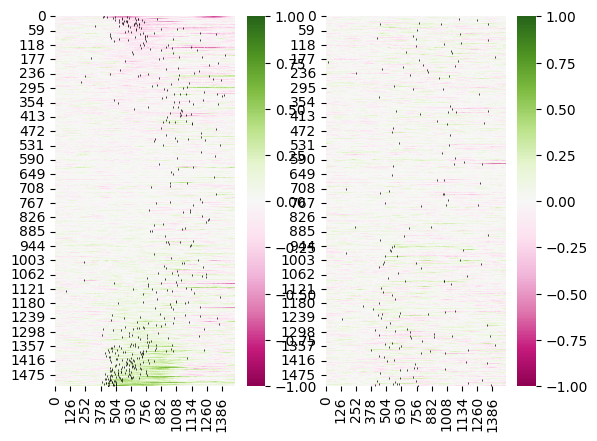

In [ ]:
# plot pfc

sort_neutral    =   np.argsort(np.mean(all_pfc_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(all_pfc_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(all_pfc_color_value[:,450:900], axis=1))

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(all_pfc_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(all_pfc_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(all_pfc_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_pfc_neutral[sort_neutral], np.arange(lat_pfc_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_pfc_orient[sort_orient], np.arange(lat_pfc_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_pfc_color[sort_color], np.arange(lat_pfc_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)


plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_pfc.pdf')  


In [ ]:
# plot v4

sort_neutral    =   np.argsort(np.mean(all_v4_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(all_v4_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(all_v4_color_value[:,450:900], axis=1))

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(all_v4_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(all_v4_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(all_v4_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_v4_neutral[sort_neutral], np.arange(lat_v4_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_v4_orient[sort_orient], np.arange(lat_v4_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_v4_color[sort_color], np.arange(lat_v4_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)


plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_v4.pdf')  


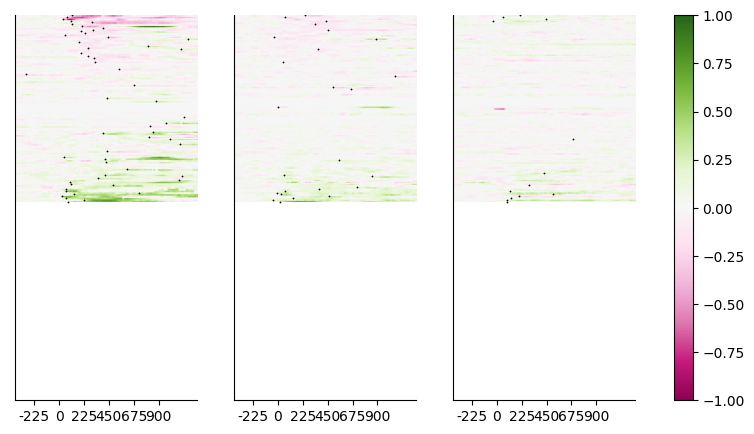

In [46]:
# plot LIP

sort_neutral    =   np.argsort(np.mean(all_lip_s_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(all_lip_s_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(all_lip_s_color_value[:,450:900], axis=1))

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(all_lip_s_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(all_lip_s_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(all_lip_s_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_lip_neutral[sort_neutral], np.arange(lat_lip_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_lip_orient[sort_orient], np.arange(lat_lip_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_lip_color[sort_color], np.arange(lat_lip_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)


plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_lip.pdf')  


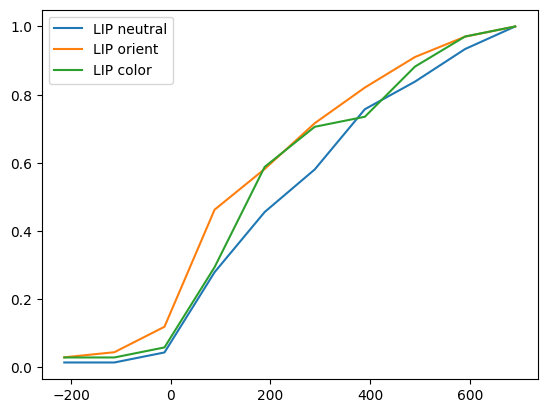

In [ ]:

count_lip_neutral, bins_count = np.histogram(lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)], bins=10) 
pdf_lip_neutral = count_lip_neutral / sum(count_lip_neutral) 
cdf_lip_neutral = np.cumsum(pdf_lip_neutral) 

count_lip_orient, bins_count = np.histogram(lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)], bins=10) 
pdf_lip_orient = count_lip_orient / sum(count_lip_orient) 
cdf_lip_orient = np.cumsum(pdf_lip_orient) 

count_lip_color, bins_count = np.histogram(lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)], bins=10) 
pdf_lip_color = count_lip_color / sum(count_lip_color) 
cdf_lip_color = np.cumsum(pdf_lip_color) 

plt.plot(bins_count[1:]-400, cdf_lip_neutral, label="LIP neutral") 
plt.plot(bins_count[1:]-400, cdf_lip_orient, label="LIP orient") 
plt.plot(bins_count[1:]-400, cdf_lip_color, label="LIP color") 
plt.legend() 